In [1]:
from fastai.vision.widgets import *
from fastai.vision.all import *

from pathlib import Path

import streamlit as st

from pydub import AudioSegment
import librosa
import librosa.display
import skimage.io

from os import listdir
from os.path import isfile, join
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

import pandas as pd

import torchvision.models as models
from pydub import AudioSegment 

In [2]:
get_x = lambda x:Path('.')/'all'/f'{x[0]}'
get_y = lambda x:x[1]

def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

def scale_minmax(X, min=0.0, max=1.0):
    """
        Scale an image

        Parameters
        ----------
        X: 2d image mesh to be scaled
        min, max: all points will be scaled within these values
    """

    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


In [3]:
input_fn='/home/mr.bwolfe/Downloads/XC611837 - Northern Bobwhite - Colinus virginianus.mp3'

In [4]:
tmpxc = AudioSegment.from_file(input_fn)

In [5]:
tmpxc.export('tmp.wav', format='wav')

<_io.BufferedRandom name='tmp.wav'>

In [6]:
#Upload the field data
xc,sr= librosa.load('tmp.wav',sr=48000)
xc

array([ 0.        ,  0.        ,  0.        , ..., -0.04629517,
       -0.04815674, -0.03518677], dtype=float32)

In [7]:
n_mels=256
hop_length=512

#Upload the field data
#xc,sr= librosa.load(input_fn,sr=48000)
xc,sr= librosa.load(input_fn,sr=48000)

mels = librosa.feature.melspectrogram(y=xc, sr=sr, n_mels=n_mels,
                        n_fft=hop_length*4, hop_length=hop_length, fmin=1000, fmax=14000, power=1)

logmel = librosa.amplitude_to_db(mels, ref=np.max)
pcen = librosa.pcen(mels * (2**31), time_constant=1.0,bias=10, gain=0.8, eps=1e-06,power=0.25,hop_length=hop_length)

img = scale_minmax(pcen, 0, 255).astype(np.uint8)
img = np.flip(img, axis=0) # put low frequencies at the bottom in image
img = 255-img # invert. make black==more energy
#skimage.io.imsave('birds.jpg', img)

chunksize=64

for i in range(int(np.floor(img.shape[1]/chunksize-1))):
    imCrop=img[:,chunksize*i:chunksize*i+256]
    if (imCrop.shape[1]<256):
        pad=np.ones((256, 256))*np.mean(imCrop)
        pad[:,0:imCrop.shape[1]]=imCrop
        imCrop=pad.astype(np.uint8)
    fn='./test/'+str(i)+'.jpg'
    skimage.io.imsave(fn, imCrop)

/home/mr.bwolfe/.conda/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/mr.bwolfe/.conda/envs/myenv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [8]:
aspect=np.floor(pcen.shape[1]/pcen.shape[0])

In [9]:
SMALL_SIZE = 14
MEDIUM_SIZE = 26
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

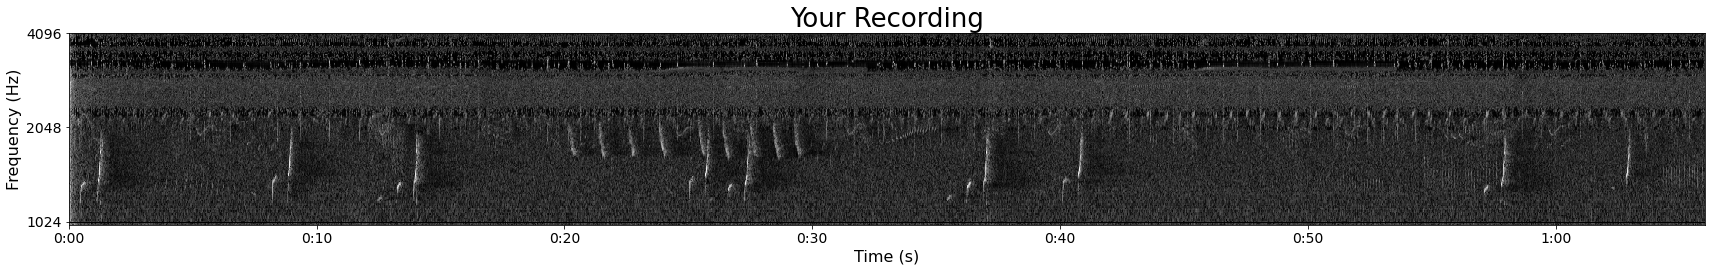

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(aspect,4))

imgpcen = librosa.display.specshow(pcen, x_axis='time', y_axis='mel', ax=ax, sr=sr, cmap='gray', fmin=1000, fmax=4096)

ax.set(title='Your Recording')
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_ylabel('Frequency (Hz)', fontsize=16)
plt.tight_layout()
fig.savefig('birds.jpg')
#plt.close(fig)

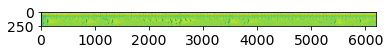

In [11]:
plt.imshow(img)

In [12]:
bs = 8 #smaller batch size is better for training, but may take longer
sz = 256
df=pd.read_pickle("short_df.pkl")
mean=torch.load('mean.pt')
std=torch.load('std.pt')
batch_tfms = [*aug_transforms(do_flip=False, max_rotate=0.0, max_zoom=1.05, max_lighting=0.1, max_warp=0.0, p_affine=0.5, p_lighting=0.5),Normalize.from_stats(mean,std)]
birds_multi = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
         get_x=get_x,
         splitter=RandomSplitter(),
         get_y=Pipeline([get_y, lambda label: [label]]),
         item_tfms=[RandomCrop(256)],
         batch_tfms=batch_tfms)
dls = birds_multi.dataloaders(df, bs=bs)
learn = cnn_learner(dls, models.vgg16, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.5),partial(F_score, threshold=0.5)], loss_func=BCEWithLogitsLossFlat(thresh=0.5)).to_fp16()

learn.load('testreserved_thresh05')

In [13]:
ntest=len(glob.glob('./test/*'))

allnames=[]

for i in range(ntest): allnames=np.append(allnames,str(i)+'.jpg')
preds=[]
preds=np.append(preds,np.repeat(0.5,len(allnames)))

test_df=pd.DataFrame({'fname':allnames,'type':preds})
test_files = get_image_files('./test')
test_dl = dls.test_dl(test_files)
preds, y = learn.get_preds(dl=test_dl,reorder=False)
preds=preds.numpy()

In [14]:
def extract_truth(preds,mydist,mytol):
    times = pd.DataFrame()

    if (len(preds)<2):

        bvpeaks=np.where(preds[:,0]>mytol)[0]
        dcpeaks=np.where(preds[:,1]>mytol)[0]
        empeaks=np.where(preds[:,2]>mytol)[0]
        nbpeaks=np.where(preds[:,3]>mytol)[0]
        pbpeaks=np.where(preds[:,4]>mytol)[0]
        
        peaks=np.array((bvpeaks,dcpeaks,empeaks,nbpeaks,pbpeaks),dtype=object)
        return peaks
    else:
        bvpeaks=[]
        dcpeaks=[]
        pbpeaks=[]
        nbpeaks=[]
        empeaks=[]

        x=np.where(preds[:,0]>mytol)[0].reshape(-1,1)
        if ((np.where(preds[:,0]>mytol)[0]).size!=0):
            kde = KernelDensity(kernel='gaussian').fit(x)

            s = np.arange(0,len(preds[:,0]))
            e = kde.score_samples(s.reshape(-1,1))
            bvpeaks, _ = find_peaks(e, distance=mydist,height=-10)

        x=np.where(preds[:,1]>mytol)[0].reshape(-1,1)
        if ((np.where(preds[:,1]>mytol)[0]).size!=0):
            kde = KernelDensity(kernel='gaussian').fit(x)

            s = np.arange(0,len(preds[:,1]))
            e = kde.score_samples(s.reshape(-1,1))
            dcpeaks, _ = find_peaks(e, distance=mydist,height=-10)

        x=np.where(preds[:,2]>mytol)[0].reshape(-1,1)
        if ((np.where(preds[:,2]>mytol)[0]).size!=0):

            kde = KernelDensity(kernel='gaussian').fit(x)

            s = np.arange(0,len(preds[:,2]))
            e = kde.score_samples(s.reshape(-1,1))
            empeaks, _ = find_peaks(e, distance=mydist,height=-10)

        x=np.where(preds[:,3]>mytol)[0].reshape(-1,1)
        if ((np.where(preds[:,3]>mytol)[0]).size!=0):

            kde = KernelDensity(kernel='gaussian').fit(x)

            s = np.arange(0,len(preds[:,3]))
            e = kde.score_samples(s.reshape(-1,1))
            nbpeaks, _ = find_peaks(e, distance=mydist,height=-10)

        x=np.where(preds[:,4]>mytol)[0].reshape(-1,1)
        if ((np.where(preds[:,4]>mytol)[0]).size!=0):

            kde = KernelDensity(kernel='gaussian').fit(x)

            s = np.arange(0,len(preds[:,4]))
            e = kde.score_samples(s.reshape(-1,1))
            pbpeaks, _ = find_peaks(e, distance=mydist,height=-10)

        peaks=np.array((bvpeaks,dcpeaks,empeaks,nbpeaks,pbpeaks),dtype=object)

        return peaks

In [15]:
peaks=extract_truth(preds,1,0.94)

In [16]:
bird_output = [[]] * 5
bird_count = np.zeros(5)

In [17]:
for i in range(5):
    positive_frame=peaks[i]
    if (len(positive_frame)>0):
        fft_frame=positive_frame*chunksize+128
        librosa.frames_to_time(fft_frame, sr=48000)
        bird_output[i]=np.round(librosa.frames_to_time(fft_frame, sr=48000),2).tolist()
        bird_count[i]=len(bird_output[i])

In [18]:
labels = ['BellsVireo', 'Dickcissel', 'EasternMeadowlark', 'NorthernBobwhite', 'PaintedBunting']

In [19]:
df=pd.DataFrame({'Type':labels,'Count':bird_count})
df

,Type,Count
0,BellsVireo,0.0
1,Dickcissel,0.0
2,EasternMeadowlark,0.0
3,NorthernBobwhite,8.0
4,PaintedBunting,0.0


In [20]:
data = {'bvtimes':bird_output[0],'dctimes':bird_output[1],'emtimes':bird_output[2],'nbtimes':bird_output[3],'pbtimes':bird_output[4]}

# create the dataframe
df2 = pd.concat([pd.DataFrame(v, columns=[k]) for k, v in data.items()], axis=1)
df2

,bvtimes,dctimes,emtimes,nbtimes,pbtimes
0,NaN,NaN,NaN,2.05,NaN
1,NaN,NaN,NaN,8.87,NaN
2,NaN,NaN,NaN,13.65,NaN
3,NaN,NaN,NaN,26.62,NaN
4,NaN,NaN,NaN,36.86,NaN
5,NaN,NaN,NaN,40.28,NaN
6,NaN,NaN,NaN,58.03,NaN
7,NaN,NaN,NaN,62.81,NaN


In [21]:
pd.concat([df,df2])

,Type,Count,bvtimes,dctimes,emtimes,nbtimes,pbtimes
0,BellsVireo,0.0,NaN,NaN,NaN,NaN,NaN
1,Dickcissel,0.0,NaN,NaN,NaN,NaN,NaN
2,EasternMeadowlark,0.0,NaN,NaN,NaN,NaN,NaN
3,NorthernBobwhite,8.0,NaN,NaN,NaN,NaN,NaN
4,PaintedBunting,0.0,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,2.05,NaN
1,NaN,NaN,NaN,NaN,NaN,8.87,NaN
2,NaN,NaN,NaN,NaN,NaN,13.65,NaN
3,NaN,NaN,NaN,NaN,NaN,26.62,NaN
4,NaN,NaN,NaN,NaN,NaN,36.86,NaN
